In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from scipy.interpolate import interp1d

2022-01-22 16:20:19.573402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-22 16:20:19.573418: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# file = 'data/pantheon.txt'
syscov_file = 'data/pantheon_errors.txt'
file = 'data/lcparam_full_long.txt'
df = pd.read_csv(file, sep = " ", usecols=['zcmb', 'mb', 'dmb'])
# df = pd.read_csv(file, sep = " ")
dmag = df[['dmb']]
df = df[['zcmb', 'mb']]
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)

In [4]:
df.head()

,zcmb,mb
0,0.50309,22.93445
1,0.49480,22.88020
2,0.67767,24.03770
3,0.86650,24.34685
4,0.79857,24.36050


In [5]:
dmag = dmag.values.reshape(N,)
np.shape(dmag)

(1048,)

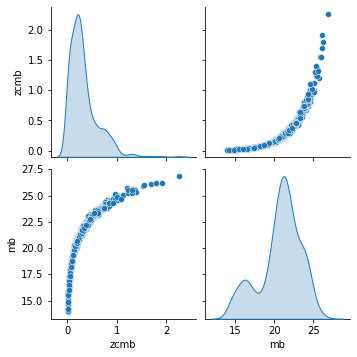

In [6]:
sns.pairplot(df, diag_kind="kde")

In [7]:
np.shape(dmag), np.shape(cov)
np.diag_indices_from(cov)

(array([   0,    1,    2, ..., 1045, 1046, 1047]),
 array([   0,    1,    2, ..., 1045, 1046, 1047]))

In [8]:
cov[np.diag_indices_from(cov)] += dmag**2
xdiag = 1/cov.diagonal() 

In [9]:
sq_errors = np.diag(syscov)
print(np.shape(sq_errors), type(sq_errors))

(1048,) <class 'numpy.ndarray'>


In [10]:
df['errors'] = np.sqrt(sq_errors+dmag**2)
df.describe()

,zcmb,mb,errors
count,1048.000000,1048.000000,1048.000000
mean,0.322314,20.747108,0.142484
std,0.285966,2.647864,0.031643
min,0.010120,13.907450,0.086315
25%,0.131682,19.607525,0.120915
50%,0.248555,21.159450,0.137935
75%,0.422712,22.479638,0.156516
max,2.260000,26.877000,0.451069


In [11]:
# df['mb'] += 19.36

/tmp/ipykernel_6189/32419971.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 2.3)


(0.00772207679255928, 2.3)

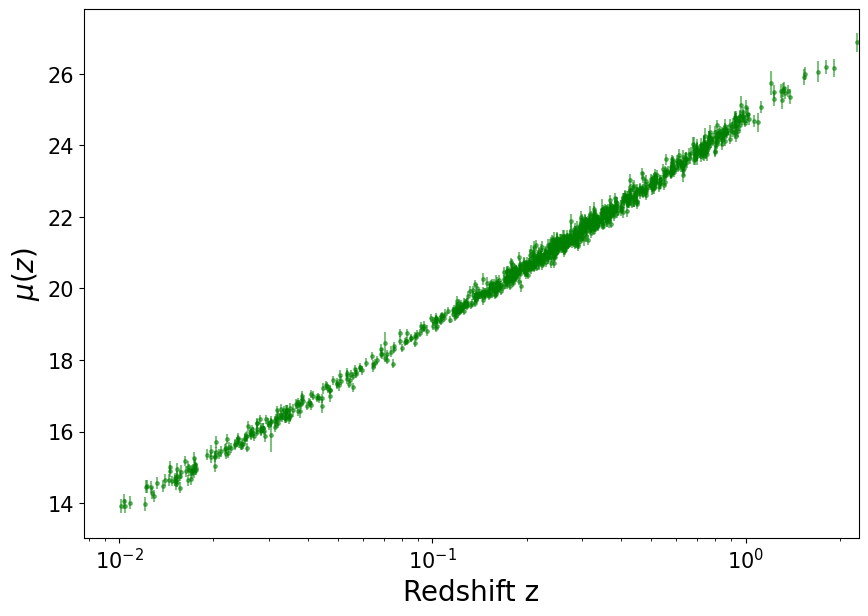

In [12]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 2.3)

In [13]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [14]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [15]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [16]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [17]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [18]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)


    return elast


input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


2022-01-22 16:20:23.851741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-22 16:20:23.851771: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-22 16:20:23.851794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isidro-pc): /proc/driver/nvidia/version does not exist
2022-01-22 16:20:23.852016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
batch_size = 4
epochs = 100
input_z = Input(shape = (1,))

In [20]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

2022-01-22 16:20:23.992627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
210/210 [==============================] - 0s 1ms/step - loss: 51.3380 - val_loss: 4.6834
Epoch 2/100
210/210 [==============================] - 0s 725us/step - loss: 1.8195 - val_loss: 0.3377
Epoch 3/100
210/210 [==============================] - 0s 711us/step - loss: 0.3021 - val_loss: 0.2376
Epoch 4/100
210/210 [==============================] - 0s 715us/step - loss: 0.2630 - val_loss: 0.2487
Epoch 5/100
210/210 [==============================] - 0s 706us/step - loss: 0.2360 - val_loss: 0.2809
Epoch 6/100
210/210 [==============================] - 0s 706us/step - loss: 0.1834 - val_loss: 0.1431
Epoch 7/100
210/210 [==============================] - 0s 708us/step - loss: 0.1486 - val_loss: 0.1242
Epoch 8/100
210/210 [==============================] - 0s 728us/step - loss: 0.1456 - val_loss: 0.0946
Epoch 9/100
210/210 [==============================] - 0s 731us/step - loss: 0.1158 - val_loss: 0.0911
Epoch 10/100
210/210 [==============================] - 0s 720us/step - lo

Epoch 80/100
210/210 [==============================] - 0s 716us/step - loss: 0.0378 - val_loss: 0.0355
Epoch 81/100
210/210 [==============================] - 0s 719us/step - loss: 0.0498 - val_loss: 0.0386
Epoch 82/100
210/210 [==============================] - 0s 714us/step - loss: 0.0622 - val_loss: 0.0791
Epoch 83/100
210/210 [==============================] - 0s 700us/step - loss: 0.0837 - val_loss: 0.0294
Epoch 84/100
210/210 [==============================] - 0s 708us/step - loss: 0.0343 - val_loss: 0.0201
Epoch 85/100
210/210 [==============================] - 0s 715us/step - loss: 0.0567 - val_loss: 0.0379
Epoch 86/100
210/210 [==============================] - 0s 711us/step - loss: 0.0333 - val_loss: 0.0185
Epoch 87/100
210/210 [==============================] - 0s 731us/step - loss: 0.0290 - val_loss: 0.0184
Epoch 88/100
210/210 [==============================] - 0s 736us/step - loss: 0.0360 - val_loss: 0.0199
Epoch 89/100
210/210 [==============================] - 0s 709us

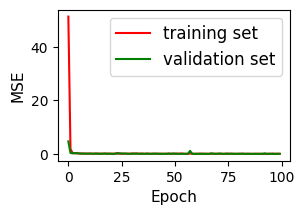

In [21]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
# plt.savefig('loss_hz.png')

In [22]:
# neural_model.save('FFNN_Hz.h5')

In [23]:
pred = neural_model.predict(z_test)
pred

array([[22.947462  ,  0.10105287],
       [20.76089   ,  0.08750276],
       [21.822866  ,  0.09492718],
       [20.86497   ,  0.08836608],
       [21.35853   ,  0.09174715],
       [20.908178  ,  0.08866285],
       [15.789024  ,  0.11742513],
       [21.957552  ,  0.09577619],
       [21.964703  ,  0.09581684],
       [21.996658  ,  0.09600876],
       [21.112902  ,  0.09006433],
       [20.846182  ,  0.08822761],
       [24.799362  ,  0.12764095],
       [20.577463  ,  0.08599059],
       [15.050855  ,  0.13090228],
       [22.996927  ,  0.10127209],
       [20.312258  ,  0.08425622],
       [15.58322   ,  0.12089674],
       [22.050543  ,  0.09634964],
       [21.82488   ,  0.09494142],
       [21.428272  ,  0.0922244 ],
       [22.303253  ,  0.09795587],
       [21.705227  ,  0.09412067],
       [22.137617  ,  0.09690337],
       [14.98608   ,  0.1325197 ],
       [16.545788  ,  0.10466205],
       [21.794222  ,  0.09473102],
       [24.5658    ,  0.11926423],
       [19.83172   ,

In [24]:
# ranz = np.random.uniform(0, 2, size=10000)
ranz = np.linspace(0, 2, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

(0.0, 2.3)

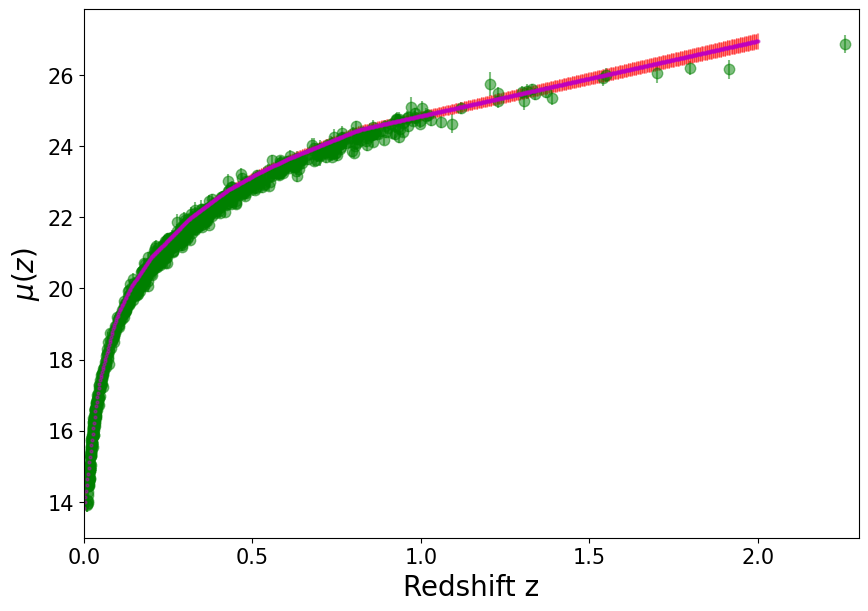

In [25]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlim(0, 2.3)
# plt.savefig("20_epochs_HD.png")

In [34]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

Text(0.5, 0, 'Redshift $z$')

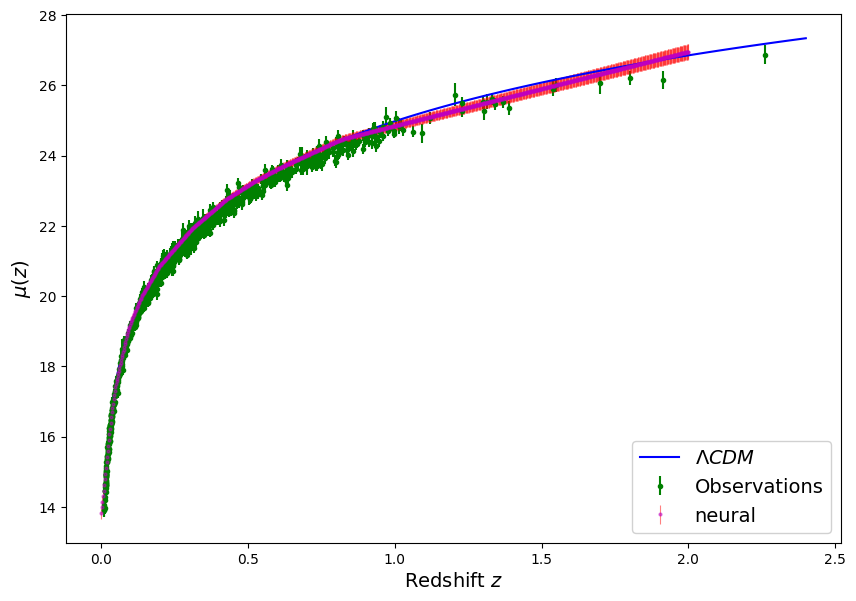

In [46]:
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(df['zcmb'], df['mb'], yerr=df['errors'], fmt='g.', label='Observations')
# plt.plot(df['zcmb'], df['mb'], c='g')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m', label='neural')
plt.ylabel("$\mu(z)$", fontsize=14)
plt.legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=1)

                            


plt.xlabel('Redshift $z$', fontsize=14)



In [ ]:
def model2(input_z):
    x = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(x)
    x = Dense(150, activation='relu')(x)
    elast = Dense(2, activation='linear')(x)


    return elast


input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

#### Now, we not use the statistical error and only use a ANN to given redshift predict $\mu(z)$. And we estimates its uncertainty with dropout layers.

In [47]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((838, 1), (838, 1), (210, 1), (210, 1))

In [48]:
from astroNN.nn.layers import MCDropout

In [49]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, y_test))

/home/isidro/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/800
210/210 [==============================] - 0s 1ms/step - loss: 205.9577 - val_loss: 179.3185
Epoch 2/800
210/210 [==============================] - 0s 769us/step - loss: 113.0866 - val_loss: 45.4084
Epoch 3/800
210/210 [==============================] - 0s 754us/step - loss: 36.5922 - val_loss: 27.2236
Epoch 4/800
210/210 [==============================] - 0s 744us/step - loss: 26.1901 - val_loss: 21.2817
Epoch 5/800
210/210 [==============================] - 0s 763us/step - loss: 20.7897 - val_loss: 15.6966
Epoch 6/800
210/210 [==============================] - 0s 759us/step - loss: 15.9431 - val_loss: 13.0478
Epoch 7/800
210/210 [==============================] - 0s 748us/step - loss: 13.6825 - val_loss: 10.6068
Epoch 8/800
210/210 [==============================] - 0s 753us/step - loss: 9.7228 - val_loss: 8.7490
Epoch 9/800
210/210 [==============================] - 0s 767us/step - loss: 9.8307 - val_loss: 7.8480
Epoch 10/800
210/210 [==============================] - 0s

210/210 [==============================] - 0s 754us/step - loss: 2.0727 - val_loss: 2.5803
Epoch 80/800
210/210 [==============================] - 0s 762us/step - loss: 2.0776 - val_loss: 2.3869
Epoch 81/800
210/210 [==============================] - 0s 782us/step - loss: 2.1399 - val_loss: 2.0777
Epoch 82/800
210/210 [==============================] - 0s 783us/step - loss: 1.9724 - val_loss: 2.0468
Epoch 83/800
210/210 [==============================] - 0s 773us/step - loss: 2.1856 - val_loss: 2.1483
Epoch 84/800
210/210 [==============================] - 0s 770us/step - loss: 2.2414 - val_loss: 1.8698
Epoch 85/800
210/210 [==============================] - 0s 764us/step - loss: 2.1316 - val_loss: 2.1557
Epoch 86/800
210/210 [==============================] - 0s 769us/step - loss: 1.9811 - val_loss: 2.2148
Epoch 87/800
210/210 [==============================] - 0s 777us/step - loss: 1.9213 - val_loss: 2.3412
Epoch 88/800
210/210 [==============================] - 0s 767us/step - loss:

210/210 [==============================] - 0s 772us/step - loss: 1.7416 - val_loss: 2.1993
Epoch 158/800
210/210 [==============================] - 0s 724us/step - loss: 1.6723 - val_loss: 1.7217
Epoch 159/800
210/210 [==============================] - 0s 728us/step - loss: 1.8041 - val_loss: 1.8747
Epoch 160/800
210/210 [==============================] - 0s 762us/step - loss: 1.7884 - val_loss: 1.4584
Epoch 161/800
210/210 [==============================] - 0s 761us/step - loss: 1.8648 - val_loss: 1.9460
Epoch 162/800
210/210 [==============================] - 0s 757us/step - loss: 1.9976 - val_loss: 2.0664
Epoch 163/800
210/210 [==============================] - 0s 775us/step - loss: 1.7244 - val_loss: 1.8146
Epoch 164/800
210/210 [==============================] - 0s 775us/step - loss: 1.7864 - val_loss: 1.7787
Epoch 165/800
210/210 [==============================] - 0s 838us/step - loss: 1.9652 - val_loss: 1.7398
Epoch 166/800
210/210 [==============================] - 0s 768us/ste

210/210 [==============================] - 0s 754us/step - loss: 1.4963 - val_loss: 1.6127
Epoch 236/800
210/210 [==============================] - 0s 764us/step - loss: 1.8002 - val_loss: 1.5909
Epoch 237/800
210/210 [==============================] - 0s 763us/step - loss: 1.6809 - val_loss: 1.7514
Epoch 238/800
210/210 [==============================] - 0s 762us/step - loss: 1.5474 - val_loss: 1.7991
Epoch 239/800
210/210 [==============================] - 0s 733us/step - loss: 1.6013 - val_loss: 1.6336
Epoch 240/800
210/210 [==============================] - 0s 776us/step - loss: 1.7041 - val_loss: 1.5767
Epoch 241/800
210/210 [==============================] - 0s 753us/step - loss: 1.5991 - val_loss: 1.6508
Epoch 242/800
210/210 [==============================] - 0s 740us/step - loss: 1.7797 - val_loss: 1.4229
Epoch 243/800
210/210 [==============================] - 0s 735us/step - loss: 1.6577 - val_loss: 1.7132
Epoch 244/800
210/210 [==============================] - 0s 779us/ste

210/210 [==============================] - 0s 753us/step - loss: 1.6271 - val_loss: 1.4356
Epoch 314/800
210/210 [==============================] - 0s 761us/step - loss: 1.6341 - val_loss: 1.2440
Epoch 315/800
210/210 [==============================] - 0s 757us/step - loss: 1.5829 - val_loss: 1.8992
Epoch 316/800
210/210 [==============================] - 0s 747us/step - loss: 1.4362 - val_loss: 1.5982
Epoch 317/800
210/210 [==============================] - 0s 750us/step - loss: 1.5521 - val_loss: 1.4263
Epoch 318/800
210/210 [==============================] - 0s 756us/step - loss: 1.4987 - val_loss: 1.3328
Epoch 319/800
210/210 [==============================] - 0s 748us/step - loss: 1.5241 - val_loss: 1.4071
Epoch 320/800
210/210 [==============================] - 0s 784us/step - loss: 1.6047 - val_loss: 1.3639
Epoch 321/800
210/210 [==============================] - 0s 740us/step - loss: 1.4845 - val_loss: 1.4201
Epoch 322/800
210/210 [==============================] - 0s 742us/ste

210/210 [==============================] - 0s 758us/step - loss: 1.4328 - val_loss: 1.1670
Epoch 392/800
210/210 [==============================] - 0s 746us/step - loss: 1.4470 - val_loss: 1.2981
Epoch 393/800
210/210 [==============================] - 0s 745us/step - loss: 1.3259 - val_loss: 1.6149
Epoch 394/800
210/210 [==============================] - 0s 768us/step - loss: 1.5611 - val_loss: 1.4268
Epoch 395/800
210/210 [==============================] - 0s 742us/step - loss: 1.5473 - val_loss: 1.2785
Epoch 396/800
210/210 [==============================] - 0s 762us/step - loss: 1.3957 - val_loss: 1.3123
Epoch 397/800
210/210 [==============================] - 0s 766us/step - loss: 1.4144 - val_loss: 1.2809
Epoch 398/800
210/210 [==============================] - 0s 746us/step - loss: 1.4585 - val_loss: 1.3307
Epoch 399/800
210/210 [==============================] - 0s 763us/step - loss: 1.4888 - val_loss: 1.2487
Epoch 400/800
210/210 [==============================] - 0s 734us/ste

210/210 [==============================] - 0s 740us/step - loss: 1.3507 - val_loss: 1.3746
Epoch 470/800
210/210 [==============================] - 0s 763us/step - loss: 1.3588 - val_loss: 1.4794
Epoch 471/800
210/210 [==============================] - 0s 756us/step - loss: 1.3755 - val_loss: 1.5264
Epoch 472/800
210/210 [==============================] - 0s 758us/step - loss: 1.4643 - val_loss: 1.1512
Epoch 473/800
210/210 [==============================] - 0s 744us/step - loss: 1.3373 - val_loss: 1.1145
Epoch 474/800
210/210 [==============================] - 0s 756us/step - loss: 1.3375 - val_loss: 1.3313
Epoch 475/800
210/210 [==============================] - 0s 749us/step - loss: 1.3228 - val_loss: 1.4610
Epoch 476/800
210/210 [==============================] - 0s 749us/step - loss: 1.2205 - val_loss: 1.2996
Epoch 477/800
210/210 [==============================] - 0s 739us/step - loss: 1.3915 - val_loss: 1.3480
Epoch 478/800
210/210 [==============================] - 0s 752us/ste

210/210 [==============================] - 0s 772us/step - loss: 1.3001 - val_loss: 1.4530
Epoch 548/800
210/210 [==============================] - 0s 793us/step - loss: 1.3476 - val_loss: 1.1976
Epoch 549/800
210/210 [==============================] - 0s 784us/step - loss: 1.3885 - val_loss: 1.2165
Epoch 550/800
210/210 [==============================] - 0s 775us/step - loss: 1.3061 - val_loss: 1.2716
Epoch 551/800
210/210 [==============================] - 0s 754us/step - loss: 1.2313 - val_loss: 1.0224
Epoch 552/800
210/210 [==============================] - 0s 776us/step - loss: 1.2195 - val_loss: 1.1097
Epoch 553/800
210/210 [==============================] - 0s 776us/step - loss: 1.4167 - val_loss: 1.3363
Epoch 554/800
210/210 [==============================] - 0s 765us/step - loss: 1.2396 - val_loss: 1.5154
Epoch 555/800
210/210 [==============================] - 0s 781us/step - loss: 1.3767 - val_loss: 1.3650
Epoch 556/800
210/210 [==============================] - 0s 821us/ste

210/210 [==============================] - 0s 756us/step - loss: 1.2263 - val_loss: 1.3573
Epoch 626/800
210/210 [==============================] - 0s 723us/step - loss: 1.3353 - val_loss: 1.4910
Epoch 627/800
210/210 [==============================] - 0s 708us/step - loss: 1.1374 - val_loss: 1.2046
Epoch 628/800
210/210 [==============================] - 0s 747us/step - loss: 1.2718 - val_loss: 1.1682
Epoch 629/800
210/210 [==============================] - 0s 746us/step - loss: 1.2243 - val_loss: 1.2939
Epoch 630/800
210/210 [==============================] - 0s 749us/step - loss: 1.2138 - val_loss: 1.1863
Epoch 631/800
210/210 [==============================] - 0s 727us/step - loss: 1.2784 - val_loss: 1.2682
Epoch 632/800
210/210 [==============================] - 0s 730us/step - loss: 1.1662 - val_loss: 1.0651
Epoch 633/800
210/210 [==============================] - 0s 740us/step - loss: 1.1533 - val_loss: 1.2059
Epoch 634/800
210/210 [==============================] - 0s 792us/ste

210/210 [==============================] - 0s 760us/step - loss: 1.1870 - val_loss: 1.0884
Epoch 704/800
210/210 [==============================] - 0s 735us/step - loss: 1.0698 - val_loss: 1.0008
Epoch 705/800
210/210 [==============================] - 0s 742us/step - loss: 1.2179 - val_loss: 1.1088
Epoch 706/800
210/210 [==============================] - 0s 757us/step - loss: 1.1457 - val_loss: 0.9742
Epoch 707/800
210/210 [==============================] - 0s 765us/step - loss: 1.1310 - val_loss: 1.1268
Epoch 708/800
210/210 [==============================] - 0s 761us/step - loss: 1.1105 - val_loss: 0.9797
Epoch 709/800
210/210 [==============================] - 0s 754us/step - loss: 1.2546 - val_loss: 1.3404
Epoch 710/800
210/210 [==============================] - 0s 755us/step - loss: 1.2404 - val_loss: 1.2706
Epoch 711/800
210/210 [==============================] - 0s 743us/step - loss: 1.1817 - val_loss: 1.2525
Epoch 712/800
210/210 [==============================] - 0s 745us/ste

210/210 [==============================] - 0s 746us/step - loss: 1.1195 - val_loss: 1.2637
Epoch 782/800
210/210 [==============================] - 0s 741us/step - loss: 1.1587 - val_loss: 1.0025
Epoch 783/800
210/210 [==============================] - 0s 762us/step - loss: 1.1172 - val_loss: 1.0523
Epoch 784/800
210/210 [==============================] - 0s 749us/step - loss: 1.1522 - val_loss: 1.1957
Epoch 785/800
210/210 [==============================] - 0s 732us/step - loss: 1.1049 - val_loss: 1.3220
Epoch 786/800
210/210 [==============================] - 0s 756us/step - loss: 1.0616 - val_loss: 1.1621
Epoch 787/800
210/210 [==============================] - 0s 757us/step - loss: 1.0958 - val_loss: 1.1578
Epoch 788/800
210/210 [==============================] - 0s 753us/step - loss: 0.9787 - val_loss: 1.3598
Epoch 789/800
210/210 [==============================] - 0s 748us/step - loss: 1.1229 - val_loss: 0.9970
Epoch 790/800
210/210 [==============================] - 0s 735us/ste

In [50]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

In [51]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(1.7675151818855228, 0.007901076676576683)

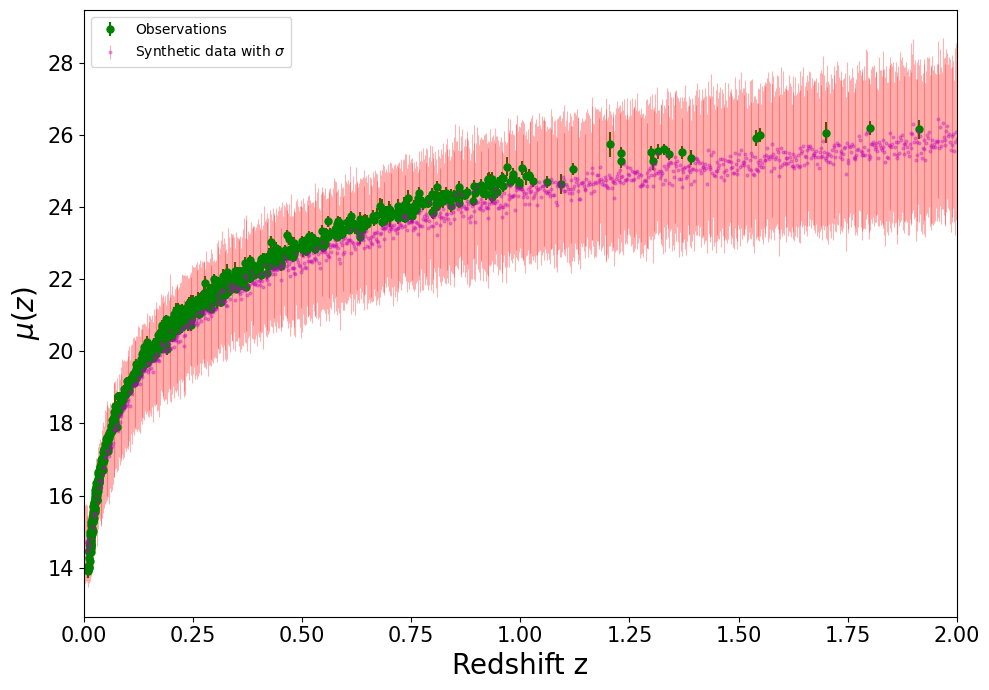

In [60]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(df['zcmb'], df['mb'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()


In [61]:
 prediction_mc_dropout[0,:]

array([14.48163661,  0.13171749])

([], [])

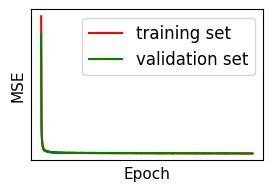

In [62]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])


In [ ]:
# model.save('FFNN+MC-DO_Hz.h5')
# tf.keras.models.save_model(neural_model2, '../models/FFNN_MC_DO.h5' )

In [63]:
mookdp = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("data.dat",mookdp, delimiter=" ")

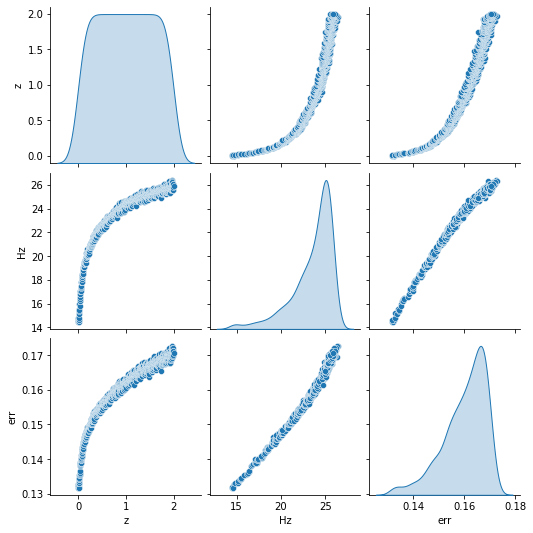

In [65]:
dfMook = pd.DataFrame(mookdp, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")